In [1]:
import sys, os

sys.path.append("../src/")

import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from deap import base, creator, tools, algorithms, gp
from gp_operators import *

%matplotlib inline

In [2]:
base_path = "../data/20ng/20ng-train.csv"
pkl_path = "../pkls/gp_doc2vec_50-50_2016-09-28.pkl"
wv_path = "../words_vectors/100x_sg_agg_gensim.txt"

In [3]:
wv_model = Word2Vec.load(wv_path)
dim = wv_model.layer1_size

In [4]:
D1 = 50
D2 = 50
docs = []
doc_matrices = []
fin = open(base_path, 'r')

for line in fin:
  id_class_text = line.split(';')
  words = set(id_class_text[2].strip().split())
  if len(words)==0:
    continue
  docs.append(id_class_text[2].strip())
  word_vectors = None
  for w in words:
    wv = None
    try:
      wv = wv_model[w]
    except:
      print "wv not found"
      continue
    if word_vectors is None:
      word_vectors = np.array([wv])
    else:
      word_vectors = np.vstack((word_vectors, wv))
  if word_vectors is None:
    continue
  input_vectors = []
  for i in range(0, D1):
    input_vectors.append(list(word_vectors[:,i]))
  doc_matrices.append(input_vectors)


print "Loading vocabulary word vectors..."
fin.seek(0)
vocab = set()
for line in fin:
  words = line.split(';')[2].strip().split()
  for w in words:
    vocab.add(w)
fin.close()

vocab_vectors = {}
for w in vocab:
  try:
    vocab_vectors[w] = wv_model[w]
  except:
    continue

Loading vocabulary word vectors...


In [5]:
print "Loading GP model..."
crossover_method = "one_point"
max_depth = 5

def generate_random_number():
    return random.uniform(-1, 1)

def generate_random_tuple():
    return D2 * (generate_random_number(),)

pset = gp.PrimitiveSetTyped("evo_doc2vec", D1*[list], tuple, "x")

pset.addEphemeralConstant("k1", generate_random_number, float)
pset.addEphemeralConstant("k2",  generate_random_tuple, tuple)

pset.addPrimitive(ident, D2*[float], tuple)
pset.addPrimitive(ident_unit, D2*[float], tuple)
pset.addPrimitive(ident_softmax, D2*[float], tuple)
pset.addPrimitive(neg, [list], list)
pset.addPrimitive(add1, [list, list], list)
pset.addPrimitive(add2, [list, float], list)
pset.addPrimitive(add3, [float, float], float)
pset.addPrimitive(sub1, [list, list], list)
pset.addPrimitive(sub2, [list, float], list)
pset.addPrimitive(sub3, [float, float], float)
pset.addPrimitive(mul1, [list, list], list)
pset.addPrimitive(mul2, [list, list], float)
pset.addPrimitive(mul3, [list, float], list)
pset.addPrimitive(mul4, [float, float], float)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax, pset=pset)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=max_depth)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# def evalClassif(individual):
#   func = toolbox.compile(expr=individual)
#   train_X, valid_X, train_Y, valid_Y = train_test_split(train_input_vectors, train_classes,
#                                                         test_size = args.validation_fraction,
#                                                         random_state = 0)
#   train_documents_vectors = []
#   for tr_iv in train_X:
#     train_documents_vectors.append(list(func(*tr_iv)))
#   valid_documents_vectors = []
#   for va_iv in valid_X:
#     valid_documents_vectors.append(list(func(*va_iv)))
#   classif = LogisticRegression()
#   classif.fit(train_documents_vectors, train_Y)
#   valid_pred_Y = classif.predict(valid_documents_vectors)
#   fitness = f1_score(valid_Y, valid_pred_Y, average="macro")
#   return fitness,

# toolbox.register("evaluate", evalClassif)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("selectElite", tools.selBest)
if crossover_method == "one_point":
    toolbox.register("mate", gp.cxOnePoint)
elif crossover_method == "one_point_lb":
    toolbox.register("mate", gp.cxOnePointLeafBiased, termpb=0.1)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

pkl_dict = pickle.load(open(pkl_path))
pop, hof = pkl_dict['population'], pkl_dict['hof']

Loading GP model...


In [6]:
# nova representacao vetorial dos documents da base de acordo
# com o melhor individuo do GP
func = toolbox.compile(expr=hof[0])
new_docs = []
for iv in docs:
    new_docs.append(list(func(*iv)))

print len(new_docs[0]) == D1

True


In [7]:
# palavras mais similares aos vetores dos documentos 
used_vocab = set()
doc_similar_words = []
for doc in new_docs:
  similars = wv_model.similar_by_vector(np.array(doc), topn=30)
  doc_similar_words.append([word for word, sim in similars])
  for word, sim in similars:
    used_vocab.add(word)

In [31]:
# preparing vectors for TSNE
tsne_vectors = []
for v in new_docs:
  tsne_vectors.append(v) 
for w in used_vocab:
  tsne_vectors.append(wv_model[w])

print "Training TSNE model..."
tsne_model = TSNE()
transformed_vectors = tsne_model.fit_transform(tsne_vectors)

Training TSNE model...


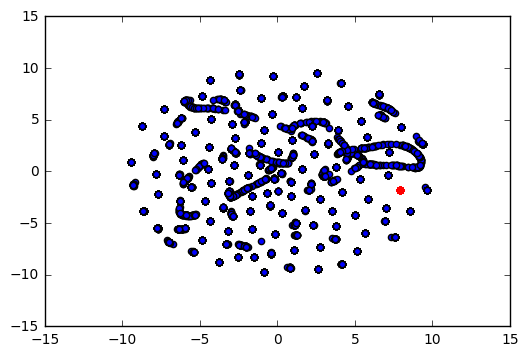

In [36]:
x = map(lambda x :x[0], transformed_vectors)
y = map(lambda x: x[1], transformed_vectors)
lmin = len(new_docs)
lmax = lmin + len(used_vocab)
plt.scatter(x[:lmin], y[:lmin])
plt.scatter(x[lmin:lmax], y[lmin:lmax], color='red')
plt.savefig("test_docs_words.png")

108 11263


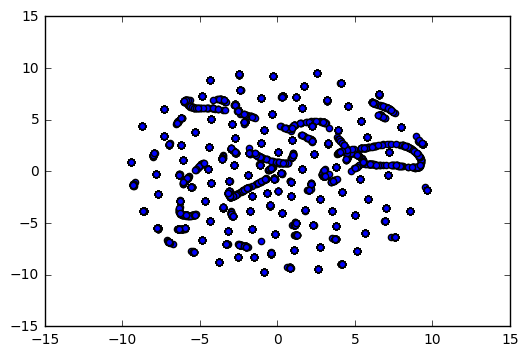

In [38]:
print len(used_vocab), len(new_docs)

plt.scatter(x[:len(new_docs)], y[:len(new_docs)])
plt.savefig("test_docs.png")

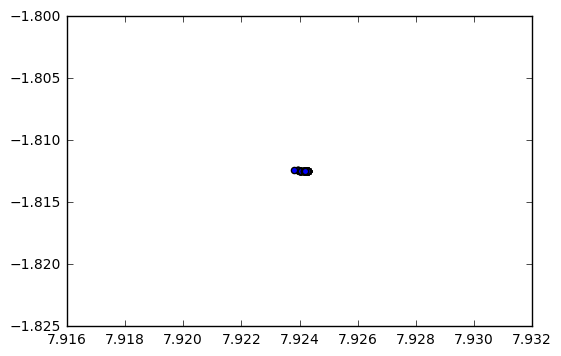

In [39]:
plt.scatter(x[lmin:lmax], y[lmin:lmax])
plt.savefig("test_words.png")

In [93]:
import random

tsne_vectors = new_docs[:]

vocvec = vocab_vectors.values()
for _ in range(5000):
  tsne_vectors.append(random.choice(vocvec))

tsne_model = TSNE()
transformed_vectors = tsne_model.fit_transform(tsne_vectors)
x = map(lambda x :x[0], transformed_vectors)
y = map(lambda x: x[1], transformed_vectors)

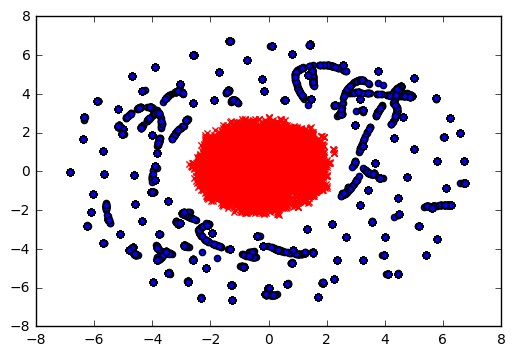

In [94]:
lmin = len(new_docs)
lmax = len(tsne_vectors)
plt.scatter(x[lmin:lmax], y[lmin:lmax], color='red', marker='x')
plt.scatter(x[:lmin], y[:lmin])

plt.savefig("test_words_docs.png")